# Tratamento 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

np.random.seed(241098)
sns.set()
sns.set(rc={'figure.figsize':(10,6)})

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import  RepeatedStratifiedKFold



In [4]:

dados = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [5]:
# #### preenchendo os valores faltantes
valor_cat = dados.iloc[:, :13]
valor_alvo = dados.iloc[:, -2:]
valor_num_columns = dados.iloc[:,13:-2].columns
valor_num = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[list(valor_num_columns)].fillna(method='bfill').fillna(method='ffill')

dados_cheios = pd.concat([valor_cat, valor_num, valor_alvo], ignore_index=True, axis=1)
dados_cheios.columns = dados.columns


In [6]:
# removendo, como no enunciado do problema pede os pacientes que foram internados na janela 0-2
a_remover = dados_cheios.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_cheios_sem_W02_ICU1 = dados_cheios.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_cheios_sem_W02_ICU1 = dados_cheios_sem_W02_ICU1.dropna()

In [7]:
# removendo as janelas
def prepare_window(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_sem_janelas = dados_cheios_sem_W02_ICU1.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False).apply(prepare_window).reset_index()
dados_sem_janelas = dados_sem_janelas.drop(columns=['level_0', 'level_1', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'])

# tranformando a coluna "AGE_PERCENTIL para ordinal"
ordinal_encoder = OrdinalEncoder()
dados_sem_janelas.AGE_PERCENTIL = ordinal_encoder.fit_transform(dados_sem_janelas[["AGE_PERCENTIL"]])
dados_para_dummy_classifier = dados_sem_janelas

In [10]:
with open('data_pick', 'wb') as pickle_file:
    pickle.dump(dados_para_dummy_classifier, pickle_file)

# Teste e refinamentos

Com o objetivo de refinar nosso modelo, vou comecar removendo as colunas com correlação muito alta(+0.95)

In [14]:

def correlacao(dados, pctcorr):
     lista_colunas_altas= set()
     matrix_correlacao = dados.iloc[:,10:-1].corr().abs()
     for i in range(len(matrix_correlacao.columns)):
          for j in range(i):
               if (matrix_correlacao.iloc[i,j]) > pctcorr:
                    nome_col = matrix_correlacao.columns[i]
                    lista_colunas_altas.add(nome_col)
     return lista_colunas_altas
correlacao(dados_para_dummy_classifier, 0.95)

colunas_para_remover = correlacao(dados_para_dummy_classifier, 0.95)
dados_finais = dados_para_dummy_classifier.drop(colunas_para_remover, axis=1)
dados_finais.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1
2,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0
4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0


O dataset passou de 229 para 98 colunas

In [20]:
# def correlacaoo(dados, pctcorr,pctcorrmenos):
#      lista_colunas_altas_baixas= set()
#      matrix_correlacao = dados.iloc[:,10:-1].corr().abs()
#      for i in range(len(matrix_correlacao.columns)):
#           for j in range(i):
#                if (matrix_correlacao.iloc[i,j]) > pctcorr:
#                     nome_col = matrix_correlacao.columns[i]
#                     lista_colunas_altas_baixas.add(nome_col)
#      for i in range(len(matrix_correlacao.columns)):
#           for j in range(i):
#                if abs((matrix_correlacao.iloc[i,j]) < pctcorrmenos):
#                     nome_col = matrix_correlacao.columns[i]
#                     lista_colunas_altas_baixas.add(nome_col)
#      return lista_colunas_altas_baixas
# correlacaoo(dados_para_dummy_classifier, 0.95, 0.05)

# colunas_para_remover = correlacaoo(dados_para_dummy_classifier, 0.95, 0.05)
# dados_finais_teste2 = dados_para_dummy_classifier.drop(colunas_para_remover, axis=1)
# dados_finais_teste2.head(50)


In [22]:

# # teste
# # correlacaoo(dados_para_dummy_classifier, 0.95, 0.05) 
# colunas_para_remover = correlacaoo(dados_para_dummy_classifier, 0.95, 0.05)
# dados_finais_teste2 = dados_para_dummy_classifier.drop(colunas_para_remover, axis=1)
# dados_finais_teste2

# def regressao_logistica(dados):
#     np.random.seed(241098)

#     y = dados["ICU"]
#     x = dados.drop(["ICU"], axis=1)
#     x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=0)
#     modelo_rl = LogisticRegression(random_state=0)
#     modelo_rl.fit(x_train, y_train)

#     y_prediction = modelo_rl.predict(x_test)
#     return print ("Acerto:",accuracy_score(y_test, y_prediction) *100)

# def floresta(dados, estimator):
#     np.random.seed(241098)

#     y = dados["ICU"]
#     x = dados.drop(["ICU"], axis=1)
#     x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)
#     modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
#     modelo_floresta.fit(x_train, y_train)
#     y_prediction = modelo_floresta.predict(x_test)
#     return print ("Acerto:",accuracy_score(y_test, y_prediction) *100)

# floresta(dados_finais_teste2, 40)
# regressao_logistica(dados_finais_teste2)

In [21]:
# colunas_para_remover = correlacao(dados_para_dummy_classifier, 0.95)
# dados_finais = dados_para_dummy_classifier.drop(colunas_para_remover, axis=1)
# dados_finais

In [ ]:
dados_para_dummy_classifier.head()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0


In [ ]:
dados_finais.head()


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,ICU
0,1,5.0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,1
2,0,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0
3,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0
4,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.428571,-0.247863,-0.826087,-0.754601,-0.984733,-1.000000,-0.976190,-0.979798,-0.986481,0


In [ ]:
def regressao_logistica(dados):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y,test_size=0.25, random_state=0)
    modelo_rl = LogisticRegression(random_state=0)
    modelo_rl.fit(x_train, y_train)

    y_pred = modelo_rl.predict(x_test)
    # return print ("Acerto:",accuracy_score(y_test, y_prediction) *100)
    # return print(classification_report(y_test, y_pred))
    return plot_confusion_matrix(modelo_rl, x_test, y_test), print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.83      0.83        47
           1       0.80      0.80      0.80        41

    accuracy                           0.82        88
   macro avg       0.82      0.82      0.82        88
weighted avg       0.82      0.82      0.82        88



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x18017e28be0>,
 None)

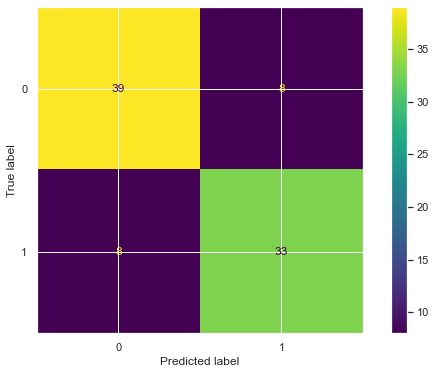

In [ ]:
regressao_logistica(dados_finais)
# sem 39 8 8 33

In [ ]:
def floresta(dados, estimator):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
    modelo_floresta.fit(x_train, y_train)
    y_pred = modelo_floresta.predict(x_test)
    # return print ("Acerto:",accuracy_score(y_test, y_prediction) *100)
    return plot_confusion_matrix(modelo_floresta, x_test, y_test), print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.78      0.76      0.77        41

    accuracy                           0.78        88
   macro avg       0.78      0.78      0.78        88
weighted avg       0.78      0.78      0.78        88



(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x18017df59c0>,
 None)

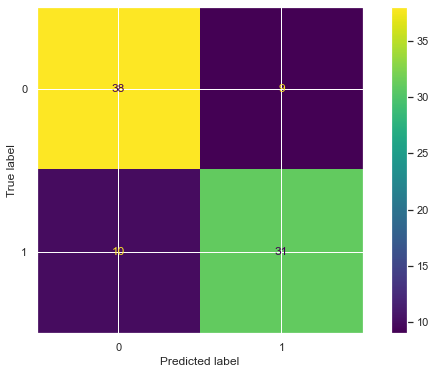

In [ ]:
floresta(dados_finais, 40)




In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle=True)
cross_validate(modelo, x, y, cv =cv)
# cross_validate(modelo, x, y, cv = 50)

cvv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10 )
cross_validate(modelo, x, y, cv =cvv)

NameError: name 'modelo' is not defined

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle=True)
cross_validate(modelo, x, y, cv =cv)
# cross_validate(modelo, x, y, cv = 50)

cvv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10 )
cross_validate(modelo, x, y, cv =cvv)

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        47
           1       0.78      0.76      0.77        41

    accuracy                           0.78        88
   macro avg       0.78      0.78      0.78        88
weighted avg       0.78      0.78      0.78        88



(0.7270824949698189,
 None)

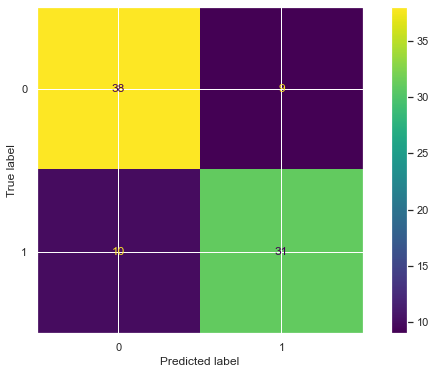

In [23]:
def floresta(dados, estimator):
    np.random.seed(241098)

    y = dados["ICU"]
    x = dados.drop(["ICU"], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, random_state=0)
    modelo_floresta = RandomForestClassifier(n_estimators=estimator, random_state=0)
    modelo_floresta.fit(x_train, y_train)
    y_pred = modelo_floresta.predict(x_test)
    # return print ("Acerto:",accuracy_score(y_test, y_prediction) *100)

    cv = StratifiedKFold(n_splits = 5, shuffle=True)
    resultados = cross_validate(modelo_floresta, x, y, cv =cv)
    # cross_validate(modelo, x, y, cv = 50)

    # cvv = RepeatedStratifiedKFold(n_splits = 5, n_repeats=10 )
    # resultados = cross_validate(modelo_floresta, x, y, cv =cv, scoring='roc_auc', return_train_score=True)

    auc_medio = np.mean(resultados['test_score'])
    # cross_validate(modelo_floresta, x, y, cv =cvv)
    return auc_medio, plot_confusion_matrix(modelo_floresta, x_test, y_test), print(classification_report(y_test, y_pred))

floresta(dados_finais, 40)
